In [1]:
import polars as pl
import polars.selectors as cs
import orjson
import numpy as np
import scipy.stats as sp


def sacred_to_df(sacred_logfile: str):
    # print(f"Reading {sacred_logfile}")
    try:
        with open(sacred_logfile, "r") as f:
            data: dict[str, list] = orjson.loads(f.read())
    except orjson.JSONDecodeError:
        return pl.DataFrame()

    res = dict[str, list]()
    length = 0
    for key, values in data.items():
        length = max(length, len(values))
        new_values = list[float]()
        for v in values:
            match v:
                case float() | int():
                    new_values.append(v)
                case dict():
                    if "py/reduce" in v:
                        # Ignore this
                        continue
                    dtype = v.get("dtype", None)
                    if dtype is None:
                        raise NotImplementedError(f"Unknown dtype: {v}")
                    match v["dtype"]:
                        case "float64":
                            new_values.append(float(v["value"]))
                        case _:
                            raise NotImplementedError(f"Unknown dtype: {v['dtype']}")
                case _:
                    raise NotImplementedError(f"Unknown: {v}")
        if len(new_values) > 0:
            if "return" in key or "episode" in key:
                continue
            key = key.replace("_", "-")
            res[key] = new_values

    # When the algorithm is still training, it is possible to have different lengths.
    # In that case, we pad the shorter ones with the last value.
    maxlen = max(len(v) for v in res.values())
    for key, values in res.items():
        if len(values) < maxlen:
            res[key] = values + [values[-1]] * (maxlen - len(values))
    df = pl.DataFrame(res)
    df = df.with_columns(pl.col("ep-length-mean-T").alias("time-step"))
    for column in df.columns:
        if column.endswith("-T") or column in ["epsilon"]:
            df = df.drop(column)
        elif column.endswith("-mean"):
            df = df.rename({column: column.replace("-mean", "")})
    return df


def round_col(df: pl.DataFrame, col_name: str, round_value: int):
    col = df[col_name] / round_value
    col = col.round(0)
    col = col * round_value
    col = col.cast(pl.Int64)
    return df.with_columns(col.alias(col_name))


def stats_by(col_name: str, df: pl.DataFrame, replace_inf: bool):
    if len(df) == 0:
        return df
    grouped = df.group_by(col_name)
    cols = [col for col in df.columns if col != col_name]
    res = grouped.agg(
        [pl.mean(col).alias(f"mean-{col}") for col in cols]
        + [pl.std(col).alias(f"std-{col}") for col in cols]
        + [pl.min(col).alias(f"min-{col}") for col in cols]
        + [pl.max(col).alias(f"max-{col}") for col in cols]
    ).sort(col_name)

    # Compute confidence intervals for 95% confidence
    # https://stackoverflow.com/questions/28242593/correct-way-to-obtain-confidence-interval-with-scipy
    confidence_intervals = []
    counts = grouped.len().sort(col_name)["len"]
    scale = (counts**0.5).to_numpy().astype(np.float32)
    for col in cols:
        mean = res[f"mean-{col}"].to_numpy().astype(np.float32)
        # Avoid zero std with +1e-8, otherwise a "inf" * 0 will be computed by scipy, leading to NaN
        std = res[f"std-{col}"].to_numpy().astype(np.float32) + 1e-8
        # Use scipy.stats.t if the sample size is small (then degree of freedom, df, is n_samples - 1)
        # Use scipy.stats.norm if the sample size is large
        lower, upper = sp.norm.interval(0.95, loc=mean, scale=std / scale)
        plus95 = pl.Series(name=f"{col}-plus95", values=upper)
        minus95 = pl.Series(name=f"{col}-minus95", values=lower)
        confidence_intervals += [plus95, minus95]

    res = res.with_columns(confidence_intervals)
    if replace_inf:
        for series in res.select(cs.float()):
            mask = series.is_infinite() | series.is_nan()
            series[mask] = 0
            res = res.with_columns(series)
    return res


# Transform Sacred to CSV

In [2]:
import os 

def get_df(folder: str):
    dfs = []
    for subfolder in os.listdir(folder):
        if not subfolder.isnumeric():
            continue
        subfolder = os.path.join(folder, subfolder)
        if not os.path.isdir(subfolder):
            continue
        file = os.path.join(subfolder, "info.json")
        if not os.path.exists(file):
            continue
        new_df = sacred_to_df(file)
        if len(new_df) > 0:
            print(f"{file} width {len(new_df.columns)}")
            dfs.append(new_df)
        else:
            print(f"Empty {file}")
    df = pl.concat(dfs)
    return df


# Plot the results

lle_6_vdn_gamma0.95/25/info.json width 11
lle_6_vdn_gamma0.95/39/info.json width 11
lle_6_vdn_gamma0.95/8/info.json width 11
lle_6_vdn_gamma0.95/7/info.json width 11
lle_6_vdn_gamma0.95/11/info.json width 11
lle_6_vdn_gamma0.95/13/info.json width 11
lle_6_vdn_gamma0.95/34/info.json width 11
lle_6_vdn_gamma0.95/35/info.json width 11
lle_6_vdn_gamma0.95/23/info.json width 11
lle_6_vdn_gamma0.95/19/info.json width 11
lle_6_vdn_gamma0.95/14/info.json width 11
lle_6_vdn_gamma0.95/36/info.json width 11
lle_6_vdn_gamma0.95/20/info.json width 11
lle_6_vdn_gamma0.95/37/info.json width 11
lle_6_vdn_gamma0.95/41/info.json width 11
lle_6_vdn_gamma0.95/27/info.json width 11
lle_6_vdn_gamma0.95/5/info.json width 11
lle_6_vdn_gamma0.95/10/info.json width 11
lle_6_vdn_gamma0.95/6/info.json width 11
lle_6_vdn_gamma0.95/29/info.json width 11
lle_6_vdn_gamma0.95/9/info.json width 11
lle_6_vdn_gamma0.95/3/info.json width 11
lle_6_vdn_gamma0.95/31/info.json width 11
lle_6_vdn_gamma0.95/40/info.json width 1

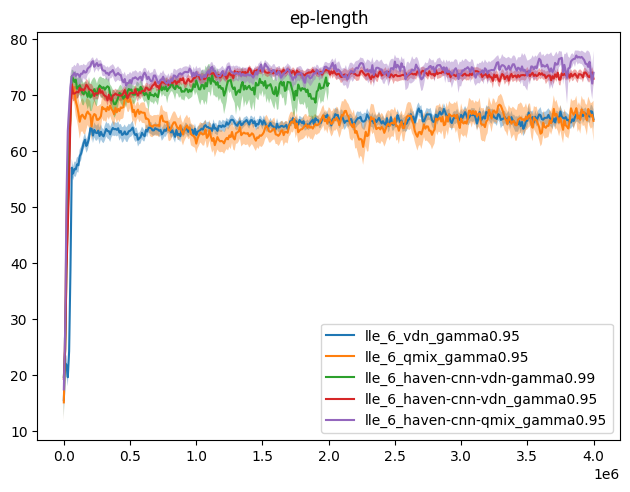

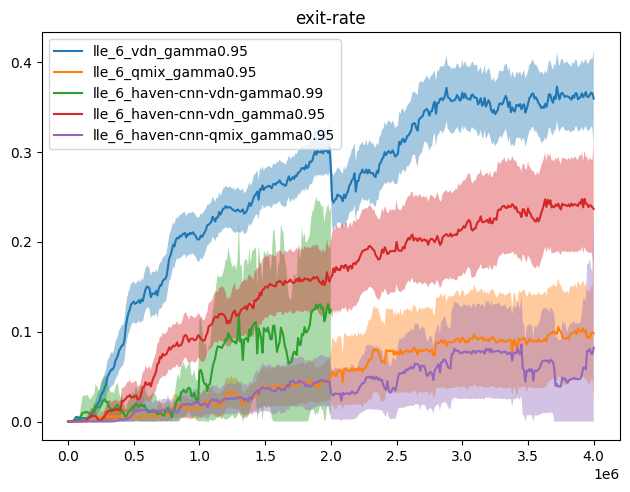

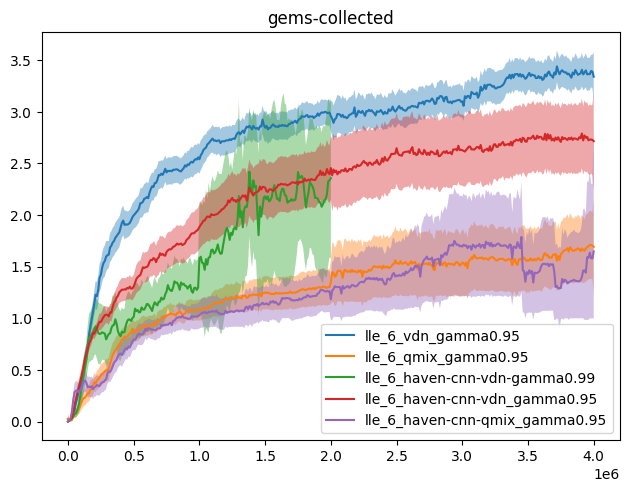

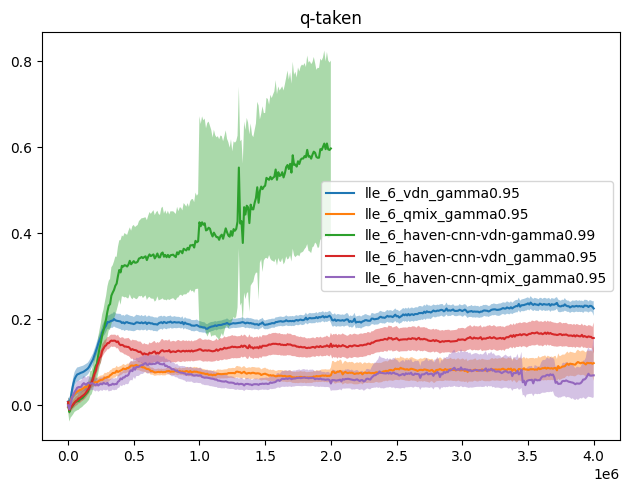

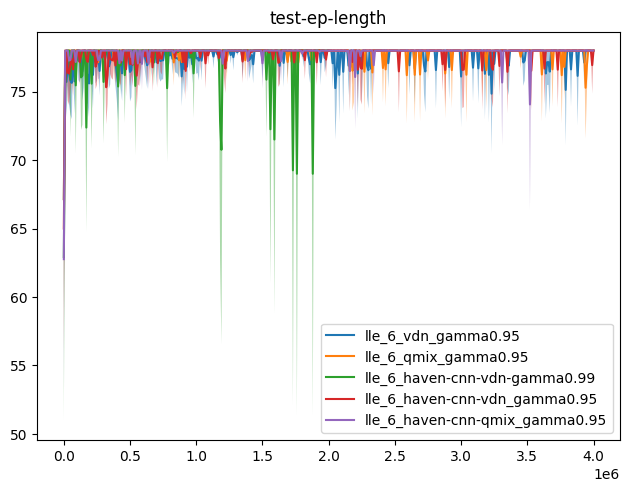

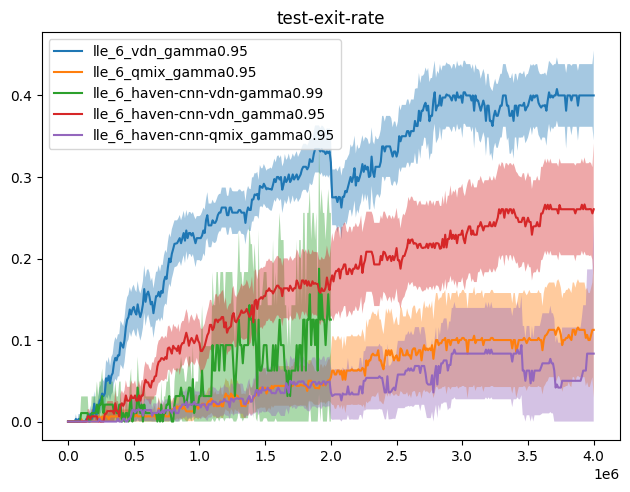

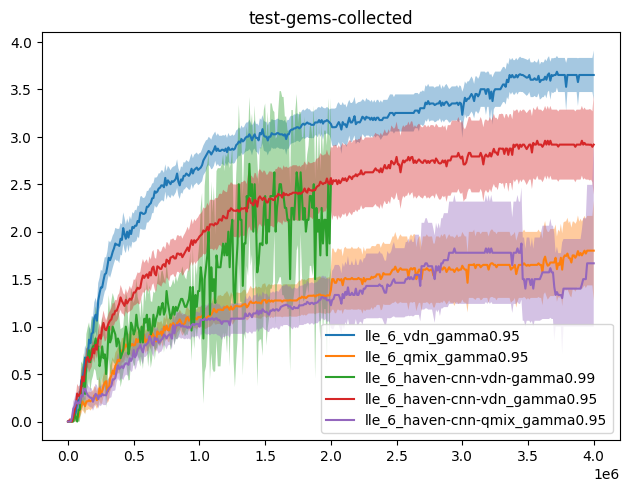

<Figure size 640x480 with 0 Axes>

In [3]:
import matplotlib.pyplot as plt
import numpy as np

bad_results = [
    "lle_6_vdn-gamma0.99",
    "lle_6_qmix-gamma0.99",
    "lle_6_haven-cnn-qmix-gamma0.99",
]
folders = [
    "lle_6_vdn_gamma0.95" , 
    "lle_6_qmix_gamma0.95",
    "lle_6_haven-cnn-vdn-gamma0.99",
    "lle_6_haven-cnn-vdn_gamma0.95",
    "lle_6_haven-cnn-qmix_gamma0.95",
]
#folders = ["lle-2lasers"]
dfs = []
for folder in folders:
    df = get_df(folder)
    dfs.append(df)
metrics = [col for col in dfs[0].columns if col != "time-step"]
dfs = [round_col(df, "time-step", 10_000) for df in dfs]
dfs = [stats_by("time-step", df, True) for df in dfs]

for metric in metrics:
    if metric in ["td-error", "loss", "target", "td-error-abs"]: 
        continue
    for label, df in zip(folders, dfs):
        minimum = np.array([df[f"{metric}-minus95"], df[f"min-{metric}"]]).max(axis=0)
        mean = df[f"mean-{metric}"]
        maximum = np.array([df[f"{metric}-plus95"], df[f"max-{metric}"]]).min(axis=0)
        plt.plot(df["time-step"], mean, label=label)
        plt.fill_between(df["time-step"], minimum, maximum, alpha=0.4)
    plt.tight_layout()
    plt.title(metric)
    plt.legend()
    plt.show()
    plt.clf()